In [1]:
# In[ ]:


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from tqdm.auto import tqdm
#from glob import glob
import time, gc
#import cv2
import tensorflow as tf
from tensorflow import keras
#import matplotlib.image as mpimg
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import clone_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input,Activation,AveragePooling2D,GlobalAveragePooling2D,Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
#from tensorflow.image import ResizeMethod
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
#import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
#import seaborn as sns
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# Enable XLA
tf.config.optimizer.set_jit(True)

# Enable AMP
tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [2]:
import os
for dirname, _, filenames in os.walk('../kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../kaggle/input\bengaliai-cv19\class_map.csv
../kaggle/input\bengaliai-cv19\sample_submission.csv
../kaggle/input\bengaliai-cv19\test.csv
../kaggle/input\bengaliai-cv19\test_image_data_0.parquet
../kaggle/input\bengaliai-cv19\test_image_data_1.parquet
../kaggle/input\bengaliai-cv19\test_image_data_2.parquet
../kaggle/input\bengaliai-cv19\test_image_data_3.parquet
../kaggle/input\bengaliai-cv19\train.csv
../kaggle/input\bengaliai-cv19\train_image_data_0.parquet
../kaggle/input\bengaliai-cv19\train_image_data_1.parquet
../kaggle/input\bengaliai-cv19\train_image_data_2.parquet
../kaggle/input\bengaliai-cv19\train_image_data_3.parquet
../kaggle/input\kalpurush-fonts\kalpurush-2.ttf


In [3]:
train_df_ = pd.read_csv('../kaggle/input/bengaliai-cv19/train.csv')
test_df_ = pd.read_csv('../kaggle/input/bengaliai-cv19/test.csv')
class_map_df = pd.read_csv('../kaggle/input/bengaliai-cv19/class_map.csv')
sample_sub_df = pd.read_csv('../kaggle/input/bengaliai-cv19/sample_submission.csv')

In [4]:
print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


In [5]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

In [6]:
IMG_SIZE=128
N_CHANNELS=1

In [7]:
batch_size = 128 # original 512
epochs = 60 # original 36

DATAPIPELINE

In [8]:
tmp0 = pd.read_parquet('../kaggle/input/bengaliai-cv19/train_image_data_0.parquet')

tmp0.columns

index0 = tmp0["image_id"]

images0 = tmp0.drop(['image_id'],axis = 1)

tran_df = train_df_[:index0.shape[0]]

Train_X = images0[:45184]
Valid_X = images0[45184:]

Train_y = tran_df[:45184]
Valid_y = tran_df[45184:]


In [9]:
Y_train_root = pd.get_dummies(Train_y['grapheme_root']).values
Y_train_vowel = pd.get_dummies(Train_y['vowel_diacritic']).values
Y_train_consonant = pd.get_dummies(Train_y['consonant_diacritic']).values


Y_valid_root = pd.get_dummies(Valid_y['grapheme_root']).values
Y_valid_vowel = pd.get_dummies(Valid_y['vowel_diacritic']).values
Y_valid_consonant = pd.get_dummies(Valid_y['consonant_diacritic']).values


In [10]:

label_train_dataset = tf.data.Dataset.from_tensor_slices({'dense_1': Y_train_root, 'dense_2': Y_train_vowel, 'dense_3': Y_train_consonant})

label_valid_dataset = tf.data.Dataset.from_tensor_slices({'dense_1': Y_valid_root, 'dense_2': Y_valid_vowel, 'dense_3': Y_valid_consonant})


In [11]:
Train_X_dataset = tf.data.Dataset.from_tensor_slices(Train_X.values)

Valid_X_dataset = tf.data.Dataset.from_tensor_slices(Valid_X.values)

In [12]:
ds_train = tf.data.Dataset.zip((Train_X_dataset, label_train_dataset))
ds_valid = tf.data.Dataset.zip((Valid_X_dataset, label_valid_dataset))

In [13]:
del Train_X
del Valid_X
del tmp0
gc.collect()

62

In [14]:
ds_train = ds_train.shuffle(batch_size*2,reshuffle_each_iteration=True).batch(batch_size).repeat()
ds_valid = ds_valid.batch(batch_size).repeat()

In [15]:
ds_train.element_spec

(TensorSpec(shape=(None, 32332), dtype=tf.uint8, name=None),
 {'dense_1': TensorSpec(shape=(None, 168), dtype=tf.uint8, name=None),
  'dense_2': TensorSpec(shape=(None, 11), dtype=tf.uint8, name=None),
  'dense_3': TensorSpec(shape=(None, 7), dtype=tf.uint8, name=None)})

## New Model

In [16]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True,
                 using_bias = False):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  use_bias=using_bias,
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 32
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True,
                    kernel_size=5,
                     
                    strides=2)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out
    
    
    #Add stage 4
    x = resnet_layer(inputs=x,
                     num_filters=num_filters_out,
                     kernel_size=1,
                     strides=2,
                     conv_first=False)
    x = resnet_layer(inputs=x,num_filters = num_filters_out,strides = 1,kernel_size = 3,conv_first=False)
    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    x = resnet_layer(inputs=x,num_filters = num_filters_out*4,strides = 1,kernel_size = 1,conv_first=False)
    #x = AveragePooling2D(pool_size=8)(x)
    
    #y = Flatten()(x)
    #y = Dense(512,activation = 'relu',kernel_initializer='he_normal')(y)
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, num_filters_out*4))(x)
    y = resnet_layer(inputs=x,
                     num_filters=num_filters_out*2,
                     kernel_size=1,
                     strides=1,
                     activation=None,
                     batch_normalization=False,
                     using_bias = True)
    #y = resnet_layer(inputs=y,
    #                 num_filters=num_filters_out,
    #                 kernel_size=1,
    #                 strides=1,
    #                 activation=None,
    #                 batch_normalization=False,
    #                 using_bias = True)
    
    y = Flatten()(y)
    
    
    head_root = Dense(168, activation = 'softmax',kernel_initializer='he_normal',dtype='float32',name = "dense_1")(y)
    head_vowel = Dense(11, activation = 'softmax',kernel_initializer='he_normal',dtype='float32',name = "dense_2")(y)
    head_consonant = Dense(7, activation = 'softmax',kernel_initializer='he_normal',dtype='float32',name = "dense_3")(y)
    # Instantiate model.
    model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])
    return model

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16 | 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 2

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
input_shape = [IMG_SIZE,IMG_SIZE,N_CHANNELS]

depth = n * 9 + 2
model_type = 'ResNet%dv%d' % (depth, version)
# In[ ]:
model = resnet_v2(input_shape=input_shape, depth=depth)

In [17]:
model.summary()
print(model_type)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   800         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [19]:
def lr_schedule(epoch):
    
    lr = 1e-3
    
    lr = 0.5*(1+np.cos((epoch/epochs)*np.pi))*lr
    print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

In [20]:
optimizer = Adam(lr=lr_schedule(0),amsgrad=True)

Learning rate:  0.001


In [21]:
def label_smooth_loss(y_true, y_pred):
    return keras.losses.categorical_crossentropy(y_true, y_pred,  label_smoothing=0.1)

In [22]:
model.compile(optimizer=optimizer, loss=label_smooth_loss, metrics=['accuracy'])#categorical_crossentropy

In [23]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_1_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_2_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [24]:
HEIGHT = 137
WIDTH = 236

### Training loop

In [25]:
from tensorflow import image as image

In [26]:
import tensorflow_addons as tfa

In [27]:
AUG_PARA={"central_fraction":0.86,
         "rotate":np.sqrt(np.pi/24)* np.random.randn(batch_size),
          "translate":tf.constant(HEIGHT/16*np.random.randn(128,2).astype(np.float32))
          #"erase":
         }

In [28]:
@tf.function
def mapped_function(s,b):
    # Do some hard pre-processing
    #print(s.shape)
    s = tf.reshape(s,(-1,HEIGHT,WIDTH, N_CHANNELS))/255
    #s = tf.random.shuffle(s)
    
    
    #central crop:
    #s_split = tf.split(s,2)
    
   
    #s0 = tf.image.central_crop(s_split[0],AUG_PARA["central_fraction"])
    #s0 = tf.image.resize(s0,[HEIGHT,WIDTH])
    #s = tf.concat([s0,s_split[1]],0)
    
    
    #random rotate
    
    s = tfa.image.rotate(s, AUG_PARA["rotate"],interpolation="BILINEAR")
    # translate:
    s = tfa.image.translate(s,AUG_PARA["translate"],interpolation="BILINEAR")
    
    
    
    #erase
    #s = tf.image.draw_bounding_boxes(s,AUG_PARA["erase"])
    
    #mixup v2
    s_split = tf.split(s,4)
    s0 = s_split[0]*0.60+s_split[1]*0.40
    s1 = s_split[1]*0.70+s_split[2]*0.30
    s2 = s_split[2]*0.80+s_split[3]*0.20
    s3 = s_split[3]*0.90+s_split[0]*0.10
    s = tf.concat([s0,s1,s2,s3],0)
    """
    r_split = tf.split(b["dense_1"],4)
    v_split = tf.split(b["dense_2"],4)
    c_split = tf.split(b["dense_3"],4)
    
    r_split = tf.cast(r_split,tf.float32)
    v_split = tf.cast(v_split,tf.float32)
    c_split = tf.cast(c_split,tf.float32)
    #print("half done")
    b_out = {}
    
    r0 = r_split[0]*0.60+r_split[1]*0.40
    r1 = r_split[1]*0.70+r_split[2]*0.30
    r2 = r_split[2]*0.80+r_split[3]*0.20
    r3 = r_split[3]*0.90+r_split[0]*0.10
    b_out["dense_1"] = tf.concat([r0,r1,r2,r3],0)
    
    v0 = v_split[0]*0.60+v_split[1]*0.40
    v1 = v_split[1]*0.70+v_split[2]*0.30
    v2 = v_split[2]*0.80+v_split[3]*0.20
    v3 = v_split[3]*0.90+v_split[0]*0.10
    b_out["dense_2"] = tf.concat([v0,v1,v2,v3],0)
    
    c0 = c_split[0]*0.60+c_split[1]*0.40
    c1 = c_split[1]*0.70+c_split[2]*0.30
    c2 = c_split[2]*0.80+c_split[3]*0.20
    c3 = c_split[3]*0.90+c_split[0]*0.10
    b_out["dense_3"] = tf.concat([c0,c1,c2,c3],0)
    """
    
    #resize
    image = tf.image.resize(s,
                            tf.constant([IMG_SIZE,IMG_SIZE]),
                            method=tf.image.ResizeMethod.BICUBIC,
                            antialias=True
                            )
#    image = tf.image.adjust_contrast(image,1.3)  # useless
    
    return image,b
    

In [29]:
ds_test_dev = tf.data.Dataset.zip((Valid_X_dataset, label_valid_dataset))

ds_test_dev = ds_test_dev.batch(128)

ds_test_dev.take(1)

ds_test_dev.map(mapped_function).take(1)

In [30]:
@tf.function
def mapped_test_function(s,b):
    # Do some hard pre-processing
    
    s = tf.reshape(s,(-1,HEIGHT,WIDTH, N_CHANNELS))/255
    image = tf.image.resize(s,
                            tf.constant([IMG_SIZE,IMG_SIZE]),
                            method=tf.image.ResizeMethod.BICUBIC,
                            antialias=True
                                    )
#    image = tf.image.adjust_contrast(image,1.3)
    
    return image,b

In [31]:
history = model.fit(ds_train.map(mapped_function,num_parallel_calls=tf.data.experimental.AUTOTUNE),
                                  epochs = epochs,
                                  steps_per_epoch=(Y_train_root.shape[0] // batch_size), 
                                    validation_data = ds_valid.map(mapped_test_function,num_parallel_calls=tf.data.experimental.AUTOTUNE),
                                    validation_steps = Y_valid_root.shape[0]//batch_size+1,
                                  callbacks=[learning_rate_reduction_root,lr_scheduler])#, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

Train for 353 steps, validate for 40 steps
Learning rate:  0.001
Epoch 1/60
353/353 [==============================] - 58s 165ms/step - loss: 9.7319 - dense_1_loss: 4.7282 - dense_2_loss: 2.0221 - dense_3_loss: 1.4598 - dense_1_accuracy: 0.0385 - dense_2_accuracy: 0.3988 - dense_3_accuracy: 0.6213 - val_loss: 9.0186 - val_dense_1_loss: 4.6491 - val_dense_2_loss: 1.5834 - val_dense_3_loss: 1.4403 - val_dense_1_accuracy: 0.0468 - val_dense_2_accuracy: 0.5322 - val_dense_3_accuracy: 0.5008
Learning rate:  0.0009993147673772868
Epoch 2/60
353/353 [==============================] - 49s 139ms/step - loss: 7.4669 - dense_1_loss: 3.9516 - dense_2_loss: 1.2227 - dense_3_loss: 1.0215 - dense_1_accuracy: 0.1436 - dense_2_accuracy: 0.7130 - dense_3_accuracy: 0.7325 - val_loss: 8.0969 - val_dense_1_loss: 4.5066 - val_dense_2_loss: 1.0797 - val_dense_3_loss: 1.2770 - val_dense_1_accuracy: 0.1421 - val_dense_2_accuracy: 0.7742 - val_dense_3_accuracy: 0.6343
Learning rate:  0.0009972609476841367
Epoch

353/353 [==============================] - 50s 140ms/step - loss: 3.3266 - dense_1_loss: 1.3673 - dense_2_loss: 0.6926 - dense_3_loss: 0.5898 - dense_1_accuracy: 0.8800 - dense_2_accuracy: 0.9485 - dense_3_accuracy: 0.9445 - val_loss: 3.2796 - val_dense_1_loss: 1.3612 - val_dense_2_loss: 0.6746 - val_dense_3_loss: 0.5755 - val_dense_1_accuracy: 0.8846 - val_dense_2_accuracy: 0.9574 - val_dense_3_accuracy: 0.9485
Learning rate:  0.0007938926261462366
Epoch 19/60
353/353 [==============================] - 49s 140ms/step - loss: 3.2932 - dense_1_loss: 1.3576 - dense_2_loss: 0.6902 - dense_3_loss: 0.5854 - dense_1_accuracy: 0.8803 - dense_2_accuracy: 0.9495 - dense_3_accuracy: 0.9475 - val_loss: 3.3012 - val_dense_1_loss: 1.3381 - val_dense_2_loss: 0.7038 - val_dense_3_loss: 0.6071 - val_dense_1_accuracy: 0.8828 - val_dense_2_accuracy: 0.9487 - val_dense_3_accuracy: 0.9499
Learning rate:  0.0007723195175075137
Epoch 20/60
353/353 [==============================] - 49s 140ms/step - loss: 3.

Learning rate:  0.0003705904774487396
Epoch 36/60
353/353 [==============================] - 49s 140ms/step - loss: 2.7648 - dense_1_loss: 1.1463 - dense_2_loss: 0.6167 - dense_3_loss: 0.5343 - dense_1_accuracy: 0.9364 - dense_2_accuracy: 0.9733 - dense_3_accuracy: 0.9687 - val_loss: 2.7882 - val_dense_1_loss: 1.1863 - val_dense_2_loss: 0.6075 - val_dense_3_loss: 0.5307 - val_dense_1_accuracy: 0.9166 - val_dense_2_accuracy: 0.9773 - val_dense_3_accuracy: 0.9717
Learning rate:  0.00034549150281252633
Epoch 37/60
353/353 [==============================] - 49s 139ms/step - loss: 2.7363 - dense_1_loss: 1.1314 - dense_2_loss: 0.6132 - dense_3_loss: 0.5321 - dense_1_accuracy: 0.9406 - dense_2_accuracy: 0.9743 - dense_3_accuracy: 0.9695 - val_loss: 2.7552 - val_dense_1_loss: 1.1777 - val_dense_2_loss: 0.6036 - val_dense_3_loss: 0.5181 - val_dense_1_accuracy: 0.9178 - val_dense_2_accuracy: 0.9773 - val_dense_3_accuracy: 0.9787
Learning rate:  0.00032081602522734986
Epoch 38/60
353/353 [=======

353/353 [==============================] - 50s 140ms/step - loss: 2.4563 - dense_1_loss: 1.0076 - dense_2_loss: 0.5696 - dense_3_loss: 0.4955 - dense_1_accuracy: 0.9728 - dense_2_accuracy: 0.9874 - dense_3_accuracy: 0.9843 - val_loss: 2.5512 - val_dense_1_loss: 1.0878 - val_dense_2_loss: 0.5780 - val_dense_3_loss: 0.5025 - val_dense_1_accuracy: 0.9427 - val_dense_2_accuracy: 0.9831 - val_dense_3_accuracy: 0.9813
Learning rate:  3.3209786751399184e-05
Epoch 54/60
353/353 [==============================] - 50s 141ms/step - loss: 2.4497 - dense_1_loss: 1.0053 - dense_2_loss: 0.5680 - dense_3_loss: 0.4942 - dense_1_accuracy: 0.9741 - dense_2_accuracy: 0.9879 - dense_3_accuracy: 0.9846 - val_loss: 2.5463 - val_dense_1_loss: 1.0851 - val_dense_2_loss: 0.5773 - val_dense_3_loss: 0.5024 - val_dense_1_accuracy: 0.9419 - val_dense_2_accuracy: 0.9831 - val_dense_3_accuracy: 0.9799
Learning rate:  2.4471741852423235e-05
Epoch 55/60
353/353 [==============================] - 49s 139ms/step - loss: 

In [32]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure(figsize=(20,20)) 
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_1_loss'], label='train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_2_loss'], label='train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_3_loss'], label='train_consonant_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_1_loss'], label='val_train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_2_loss'], label='val_train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_loss'], label='val_train_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure(figsize=(20,20))
    plt.yticks(np.arange(0.1,1.05,0.01))
    plt.xticks(np.arange(0,61,1))
    plt.plot(np.arange(0, epoch), his.history['dense_1_accuracy'], label='train_root_acc')
    plt.plot(np.arange(0, epoch), his.history['dense_2_accuracy'], label='train_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['dense_3_accuracy'], label='train_consonant_accuracy')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_1_accuracy'], label='val_root_acc')
    plt.plot(np.arange(0, epoch), his.history['val_dense_2_accuracy'], label='val_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_accuracy'], label='val_consonant_accuracy')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

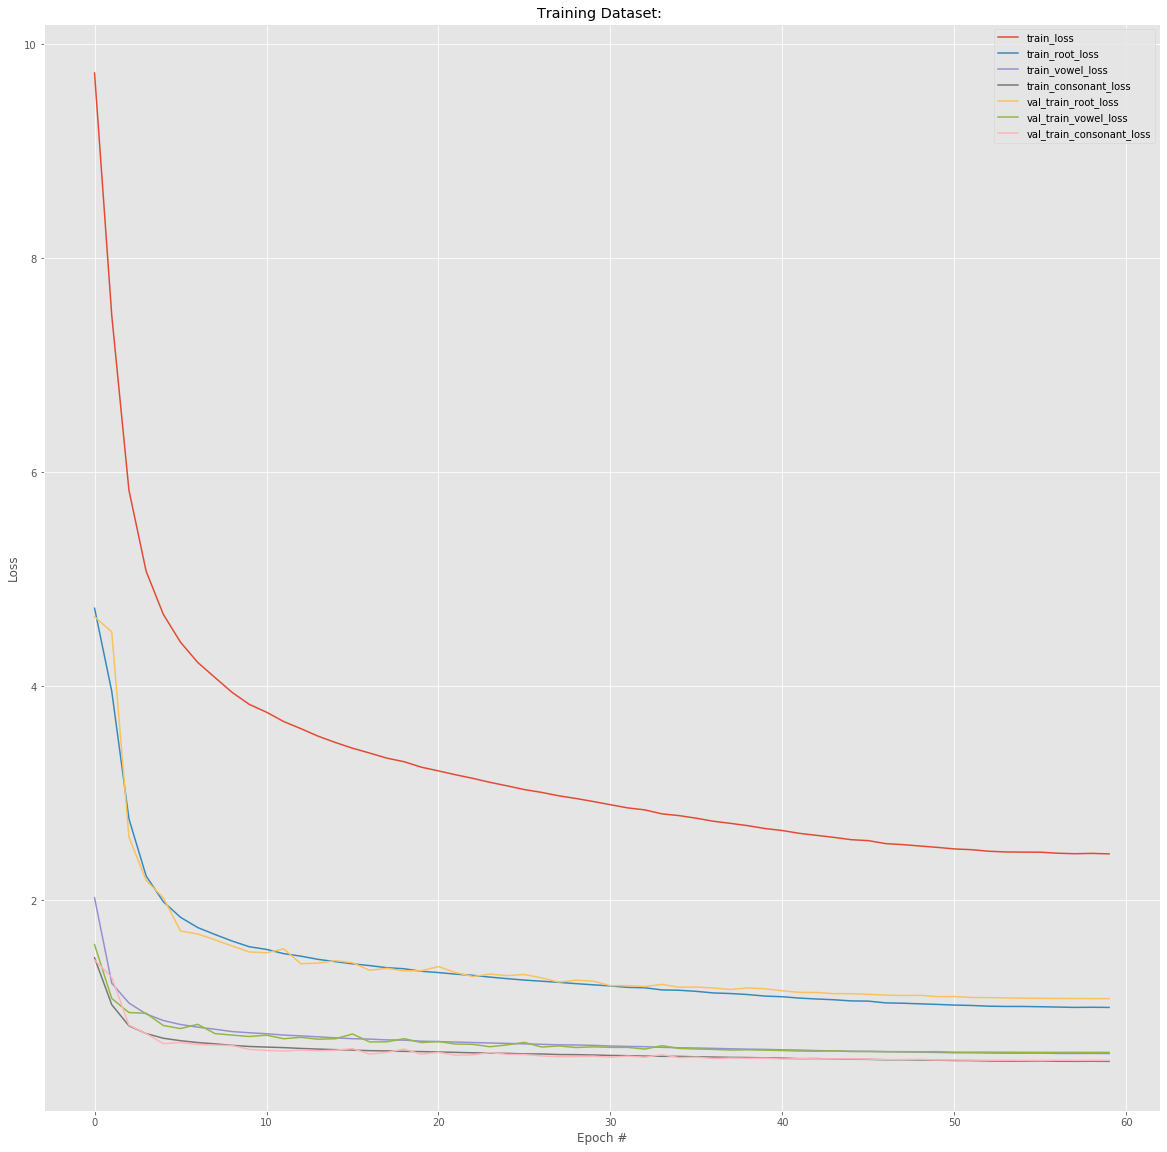

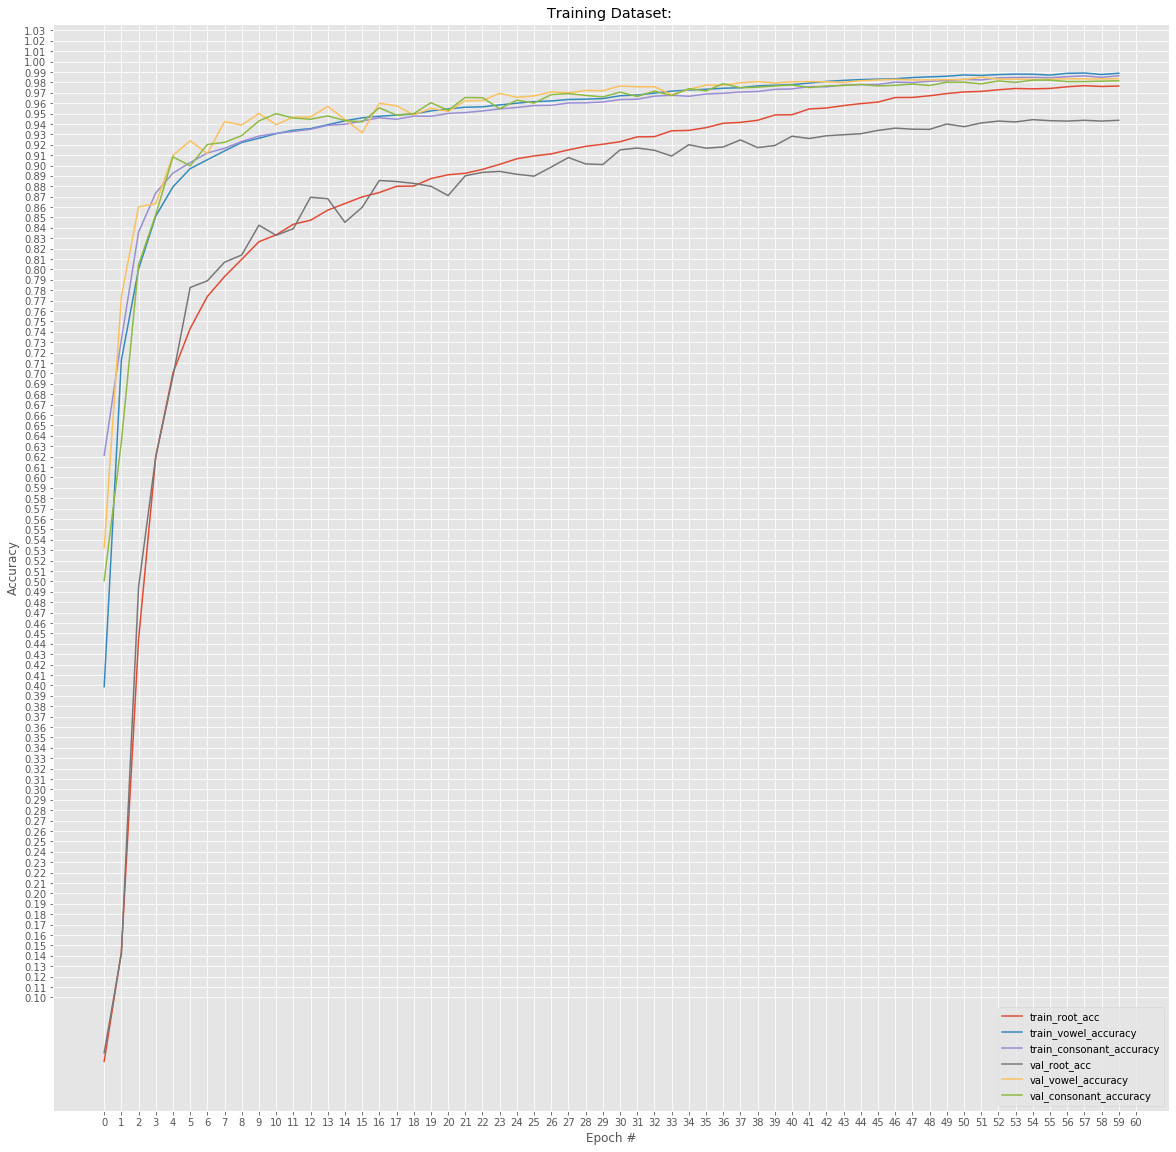

In [33]:

plot_loss(history, epochs, 'Training Dataset: ')
plot_acc(history, epochs, 'Training Dataset: ')

In [34]:
model.save_weights("aug_test_resnext20_qdata_mixup_aug.h5")

In [35]:
model.trainable = False

In [36]:
def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: Tensor of shape (N, H, W, C)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new Tensor of shape (N, H, W, C)
    """
    if ox != 0:
        left = X[:, :, :-ox]
        right = X[:, :, -ox:]
        X = tf.concat([right, left], axis=2)
    if oy != 0:
        top = X[:, :-oy]
        bottom = X[:, -oy:]
        X = tf.concat([bottom, top], axis=1)
    return X


from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X, sigma=1):
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    return X

# In[ ]:


def create_class_visualization(target_y, model, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to jitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 50)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 10)
    dense = kwargs.pop("dense_num",1)
    
    # We use a single image of random noise as a starting point
    X = np.random.rand(1,128, 128, 1)
    #X = preprocess_image(X)[None]

    loss = None # scalar loss
    grad = None # gradient of loss with respect to model.image, same size as model.image
    
    X = tf.Variable(X)
    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(0, max_jitter, 2)
        X = jitter(X, ox, oy)
        
        ########################################################################
        # TODO: Compute the value of the gradient of the score for             #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. You should use   #
        # the tf.GradientTape() and tape.gradient to compute gradients.        #
        #                                                                      #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        #X_fooling = tf.Variable(X_fooling,dtype = tf.float32)
        #one_hot_y = tf.Variable(one_hot_y,dtype = tf.float32)
        
        with tf.GradientTape() as tape:
            tape.watch(X)
            scores = model.call(X) # Forward pass of the model
            #print(tf.squeeze(scores[0]).shape)
            #taget_class_score = tf.gather_nd(scores, tf.stack((tf.range(1000), y), axis=1))
            if dense == 1:
                scores = tf.reshape(scores[0],[168])
            elif dense == 2:
                scores = tf.reshape(scores[1],[11])
            elif dense == 3:
                scores = tf.reshape(scores[2],[7])
            else:
                assert("not support")
            #print(scores.shape)
            # print(one_hot_y)
            #loss = tf.keras.losses.binary_crossentropy(y_true = one_hot_y, y_pred = scores,from_logits=False)#
            #loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=scores)
            
            #total_loss = tf.reduce_sum(loss)
            #print("loss",total_loss.numpy())
            class_y_score = tf.gather(scores,target_y)
            #class_y_score -= (l2_reg*(tf.norm(X,ord =2)))
            grad_x = tape.gradient(class_y_score, X)
            dx = l2_reg*learning_rate*grad_x/tf.norm(grad_x,ord =2)
           
            X+=(dx)     

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        
        # Undo the jitter
        X = jitter(X, -ox, -oy)
        # As a regularizer, clip and periodically blur
        
        X = tf.clip_by_value(X, 0, 1.0 )
        if t % blur_every == 0:
            X = blur_image(X, sigma=0.5)

        # Periodically show the image
        #下面注掉的是按STEP查看图片。打开后可以每10步显示一下生成的图片。
        #if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
        if t == num_iterations - 1:
            plt.imshow(np.squeeze(X))
            #class_name = class_names[target_y]
            #plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            #plt.figure(figsize=(20,20))
            plt.gcf().set_size_inches(10, 10)
            plt.axis('off')
            plt.show()
    return X


root maps
class: 0
Instructions for updating:
Use tf.identity instead.


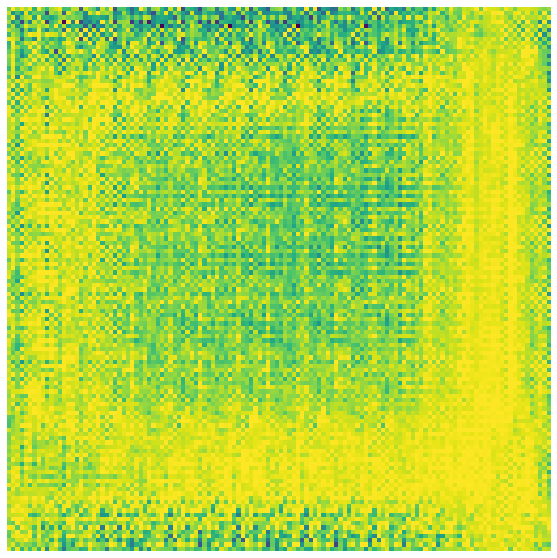

class: 1


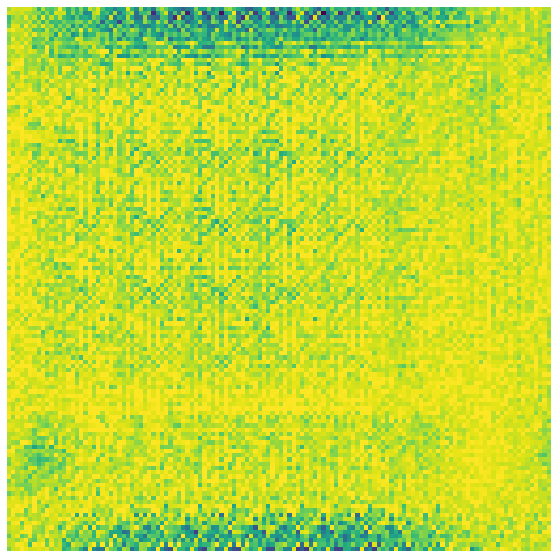

class: 2


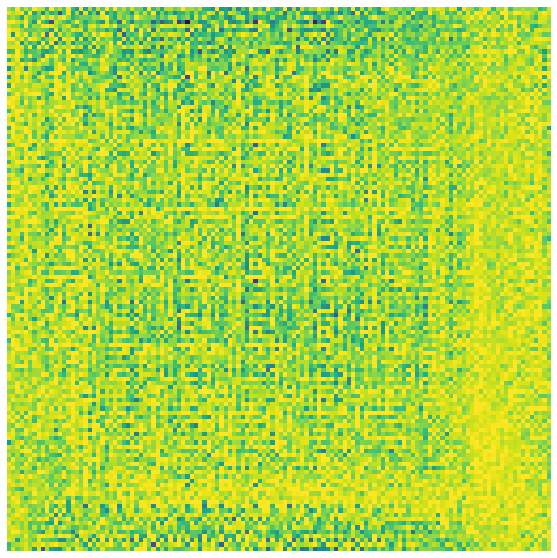

class: 3


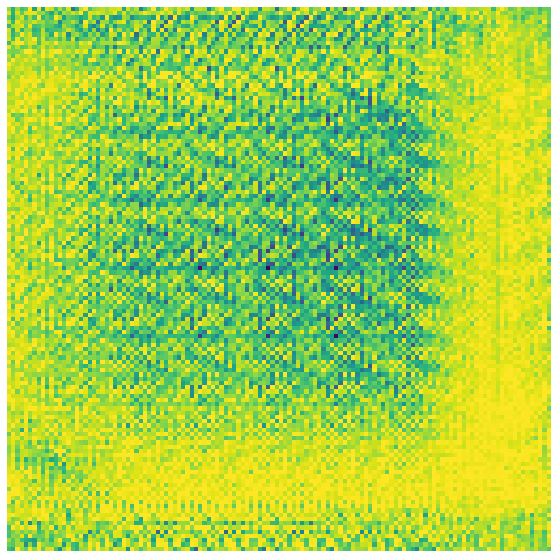

class: 4


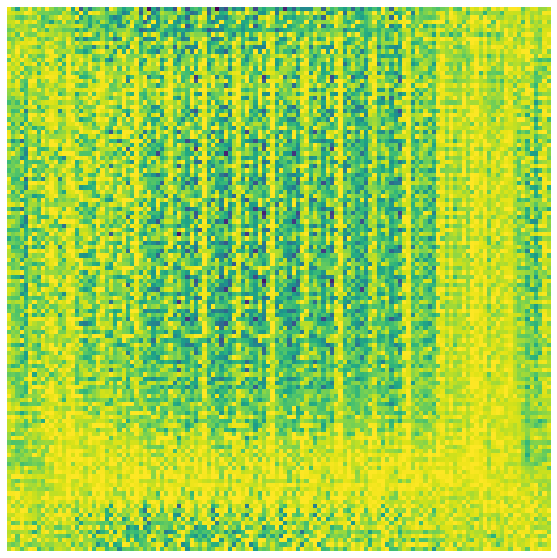

class: 5


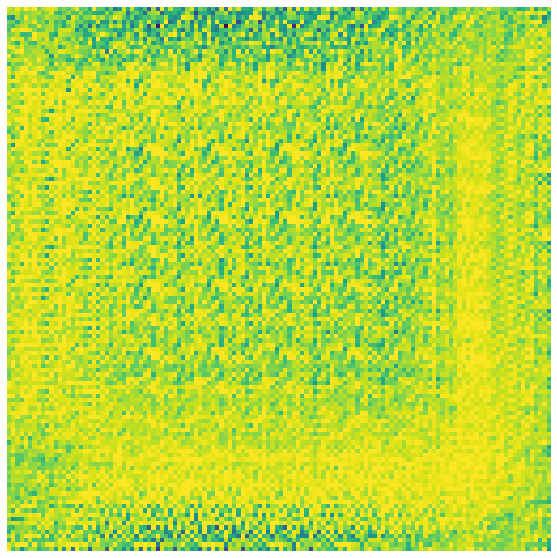

class: 6


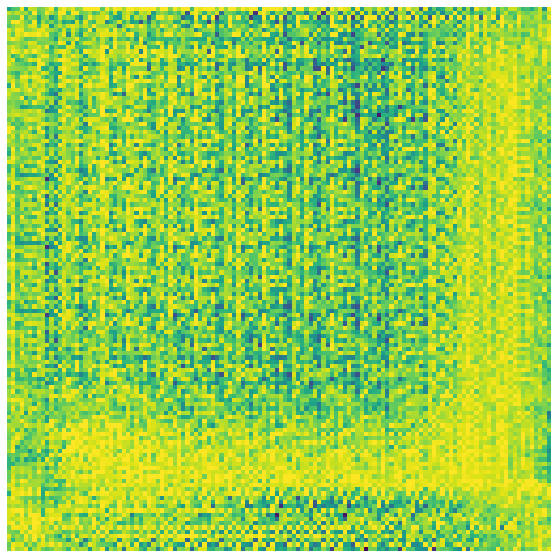

class: 7


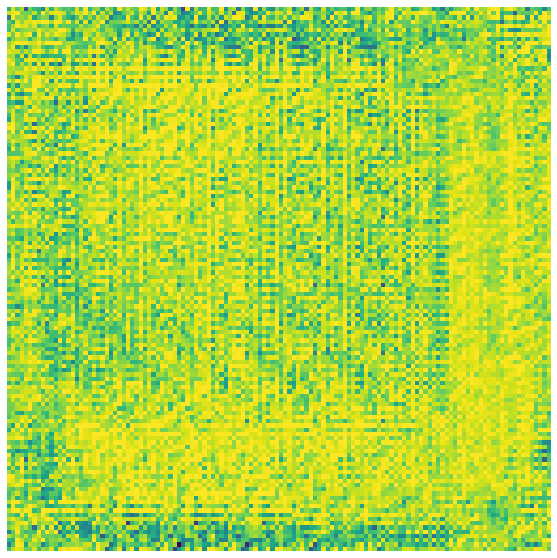

class: 8


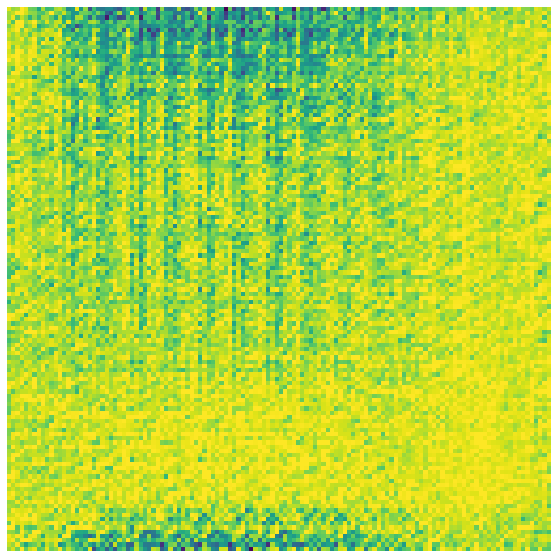

class: 9


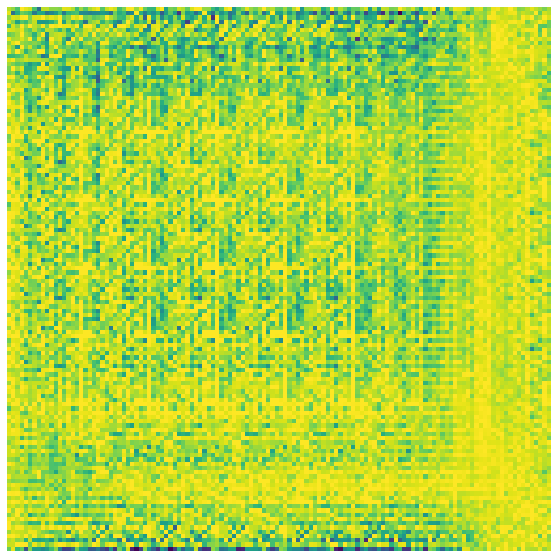

class: 10


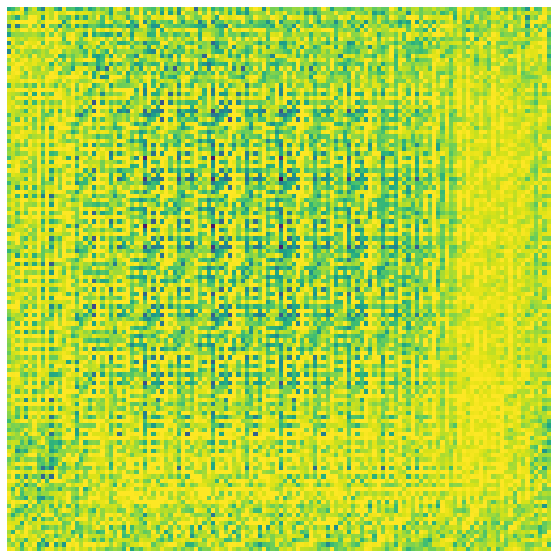

class: 11


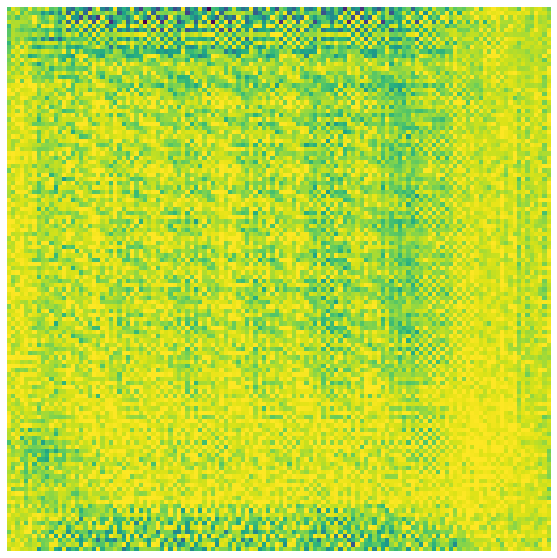

class: 12


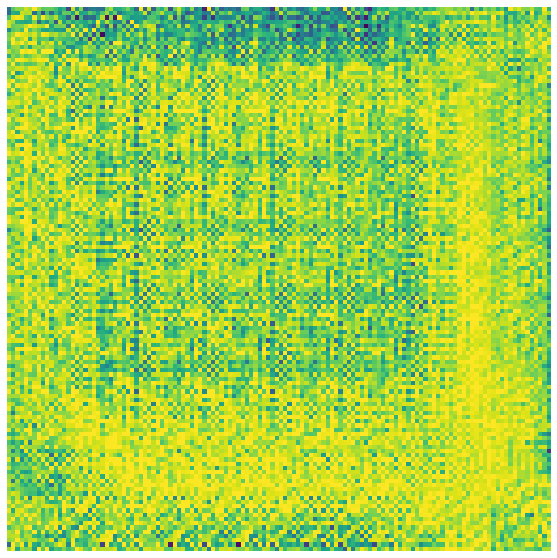

class: 13


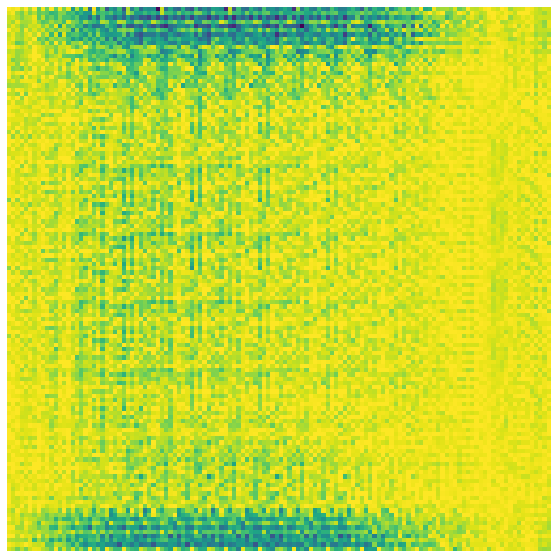

class: 14


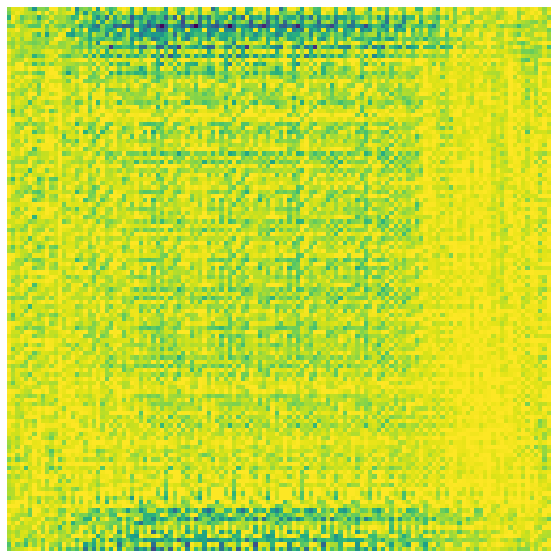

class: 15


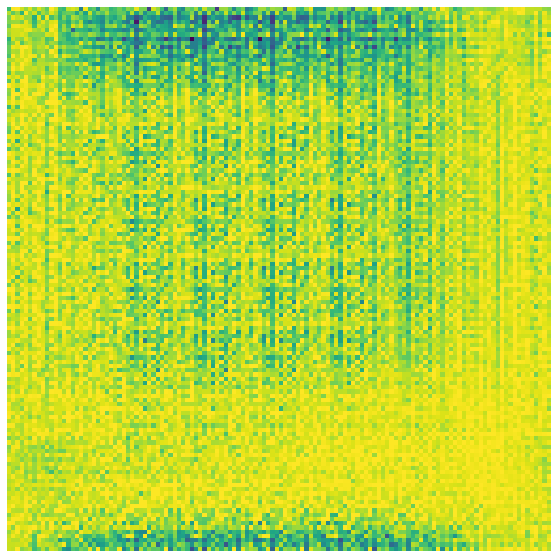

class: 16


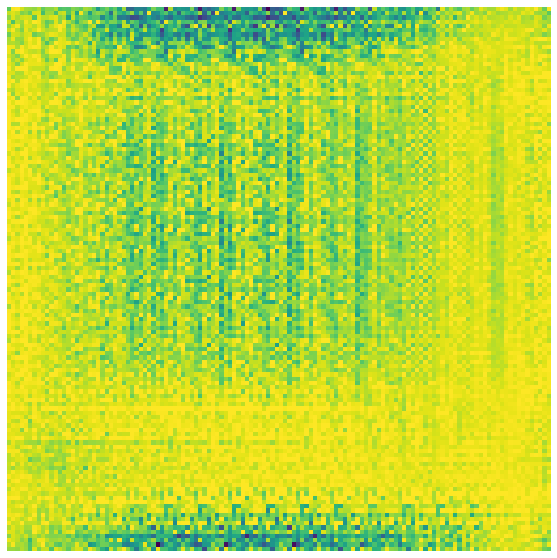

class: 17


ValueError: Passed in object of type <class 'numpy.ndarray'>, not tf.Tensor

In [37]:
print("root maps")
for i in range(168):
    target_y = i # Tarantula
    print("class:",i)
    out = create_class_visualization(target_y, model,dense = 1)
print("volort maps")
for i in range(11):
    print("class:",i)
    target_y = i # Tarantula
    out = create_class_visualization(target_y, model,dense = 2)
for i in range(7):
    target_y = i # Tarantula
    print("class:",i)
    out = create_class_visualization(target_y, model,dense = 3)